In [1]:
cmd_line_run = False
if not cmd_line_run:
    %matplotlib inline
collab_mode = False

if collab_mode and not cmd_line_run:
    # set up tensorflow in collab
    %tensorflow_version 2.x
# imports
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import warnings # This ignore all the warning messages
warnings.filterwarnings('ignore')

from os import path
import os
import time

print("Tensorflow version is", tf.__version__, ", device name", tf.test.gpu_device_name())

Tensorflow version is 2.0.0 , device name /device:GPU:0


In [2]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

# allow_memory_growth()

In [3]:
def get_time():
    return time.strftime("%d-%m-%Y_%H-%M-%S")

In [4]:
def process_image(img, image_shape):
    img = tf.cast(img, tf.float32)/127.5-1 # IMPORTANT, image's pixels are in the range <-1, 1>
    img = tf.image.resize(img, (64, 64))
    return img

def load_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    return img

def display_image_from_dataset(data):
    if cmd_line_run:
        return
    for batch in data.take(1):
        image, attributes = batch
        img_ = (image[0]+1)/2
        plt.imshow(img_)
        print(img_.shape, np.min(img_), np.max(img_))

def save_generated_image(settings, epoch):
    save_dir = settings.generated_images_path
    if not path.exists(save_dir):
        os.makedirs(save_dir)
    name = path.join(save_dir,
                     'img_{}_{}.png'.format(epoch, get_time()))
    plt.savefig(name)


def show_images(images, epoch, settings, save_images=False, display_images=False):
    print("image pixels range", np.min(images), np.max(images), "std", np.std(images))
    num_of_images = min(10, images.shape[0])
    # (x, y=1)
    plt.figure(figsize=(num_of_images, 1))
    for i in range(num_of_images):
        plt.subplot(1, num_of_images, i + 1)
        img = images[i, :, :, :].numpy() #
        img = (img * 127.5 + 127.5).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
    

    if save_images:
        save_generated_image(settings, epoch)
    if display_images and not cmd_line_run:
        plt.show()

def load_dataset(dataset_path, image_shape, use_manually_downloaded_dataset=True, preprocess_images=True, shuffle_size=500, seed=101):
    if use_manually_downloaded_dataset:
        img_path = path.join(dataset_path, '*.jpg')
        data = tf.data.Dataset.list_files(img_path, seed=seed)\
                              .shuffle(shuffle_size)\
                              .map(load_image)
        # for each image return a tuple (image, attributes), in this case we have no attributes
        if preprocess_images:
            data = data.map(lambda x: (process_image(x, image_shape), dict()))
        else:
            data = data.map(lambda x: (x, dict()))
            
    else:
        dataset_name = 'celeb_a'
        data = tfds.load(dataset_name, split=tfds.Split.TRAIN)\
                   .shuffle(shuffle_size)
        # for each image return a tuple (image, attributes), ignore 'landmarks'
        if preprocess_images:
            data = data\
                .map(lambda x: (process_image(x['image'], image_shape), x['attributes']))
        else:
            data = data\
                .map(lambda x: (x['image'], x['attributes']))
    return data

In [30]:
class Settings:
    def __init__(self, collab_mode):
        self.root_local_path = os.getcwd()
        self.root_gdrive_path = '/content/drive'
        self.gdrive_project_path = 'My Drive/pp/GSN/FaceGenerator'
        self.dataset_name = "celeb_a"
        self.subdataset_dir="1000"
        self.dataset_image_size = (28, 28)
        self.image_size = (64, 64)
        self.image_channels = 3
        self.generator_input_shape = (self.image_size[0], self.image_channels)
        self.gdrive_mounted = False
        self.collab_mode = collab_mode
        self.batch_size = 10
        self.epochs = 100
        self.save_models = False # save models at the end?
        self.mount_gdrive()
        # variables from pytorch
        self.init_w = 4 # ?
        self.init_h = 4 #?
        self.gen_init_filters = 64 # how many filters*2 (channels) should be in the first layer of the generator, n_g number in the paper
        self.df_dim = 64
        self.gf_dim=self.gen_init_filters # ?
        self.z_dim=(100, 100) # size of the vector with normal distribution noise
        self.embeddings_shape = (100, 40)
        self.n_g = self.gen_init_filters
        self.n_d = 64
        self.is_conditional=True
        self.unconditional_loss_coefficient = 1.0
        
    @property
    def run_name(self):
        return 'stack_gan_run_{}'.format(self.subdataset_dir)
        # return "{}_epochs_{}_batch_{}".format(self.epochs, self.batch_size, self.subdataset_dir)
    
    @property
    def image_shape(self):
        return (*self.image_size, self.image_channels)

    @property
    def download_path(self):
        return path.join('.', 'datasets', self.dataset_name)
    # def download_path(self):
    #     return path.join(self.get_base_path, 'datasets', self.dataset_name)

    @property
    def dataset_path(self):
        return path.join(self.download_path, self.subdataset_dir)

    @property
    def tensorboard_log_dir(self):
        return path.join(self.get_base_path, 'saved_state', self.run_name, 'tensorboard_logs')

    @property
    def checkpoint_dir(self):
        return path.join(self.get_base_path, 'saved_state', self.run_name, "ckpt")

    @property
    def model_save_path(self):
        return path.join(self.get_base_path, 'saved_state', self.run_name, 'models')
    
    @property
    def generated_images_path(self):
        return path.join(self.get_base_path, 'saved_state', self.run_name, 'generated_images')
    
    @property
    def get_base_path(self):
        if self.collab_mode:
            return path.join(self.root_gdrive_path, self.gdrive_project_path)
        else:
            return self.root_local_path

    def mount_gdrive(self):
        if self.collab_mode:
            if cmd_line_run:
                print('cmd line run, abort mounting gdrive')
                exit(-1)
            from google.colab import drive
            project_path = path.join(self.root_gdrive_path, self.gdrive_project_path)
            self.gdrive_project_path = path.join(self.root_gdrive_path, self.gdrive_project_path)
            drive.mount(self.root_gdrive_path)
            self.gdrive_mounted = True
        
            path_with_imports = path.join(self.root_gdrive_path, self.gdrive_project_path)
            print("Files in path", path_with_imports)
            !ls /content/drive/My\ Drive/pp/GSN/FaceGenerator
            if path_with_imports not in os.sys.path:
                os.sys.path.append(path_with_imports)
                
class DatasetCache:
    def __init__(self, use_manually_downloaded_dataset):
        self.path = ""
        self.batch_size = 0
        self._data = None
        # should it use dataset downloaded manually or the one downloaded by tfds
        self.use_manually_downloaded_dataset = use_manually_downloaded_dataset

    def load_data(self, settings):
        if self._data is not None and self.path == settings.dataset_path:
            self.batch_size = settings.batch_size
            return self.data
        else:
            print("downloading and loading data")
            if self.use_manually_downloaded_dataset:
                self.download_dataset(settings)
            self._data = load_dataset(
                settings.dataset_path,
                settings.image_size,
                use_manually_downloaded_dataset=self.use_manually_downloaded_dataset
            )
            self.data_path = settings.dataset_path
            self.batch_size = settings.batch_size
            return self.data
        
    @property
    def data(self):
        if self._data is None:
            return None
        else:
            return self._data.batch(self.batch_size)

    def download_dataset(self, settings):
        import dataset_helpers as ds_helpers
        '''Downloads data to dataset_path/dataset_name directory'''
        print('dataset download path is {}'.format(settings.download_path))
        ds_helpers.download_extract('celeba', settings.download_path)
        
class TensorboardManager():
    def __init__(self):
        self.log_path = ''
        self.train_summary_writer = None
        self.test_summary_writer = None
        
    def initialize(self, settings):
        should_be_updated = False
        if settings.collab_mode and self.log_path != "tensorboard_logs":
            should_be_updated = True
            self.log_path = "/content/drive/My Drive/pp/GSN/FaceGenerator/saved_state/run_img_align_celeba/tensorboard_logs"
        elif not settings.collab_mode and self.log_path != settings.tensorboard_log_dir:
            should_be_updated = True
            self.log_path = settings.tensorboard_log_dir
                
        if should_be_updated:
            self.train_summary_writer = tf.summary.create_file_writer(path.join(self.log_path, 'train'))
            self.test_summary_writer = tf.summary.create_file_writer(path.join(self.log_path, 'test'))
            print('Initialized tensorboard log dir with path', self.log_path)
            self.launch(settings.collab_mode)
        
    def launch(self, collab_mode):
        if collab_mode:
            if cmd_line_run:
                print('cmd line mode, abort launching tensorboard')
                returns
            %reload_ext tensorboard
            %tensorboard --logdir "/content/drive/My Drive/pp/GSN/FaceGenerator/saved_state/run_img_align_celeba/tensorboard_logs"
            from tensorboard import notebook
            notebook.list() # View open TensorBoard instances
        else:
            print('open tensorboard with command')
            print('tensorboard --logdir {}'.format(self.log_path))
            
    def save(self, run_type, data, description, timestamp, datatype, step):
        '''
        run_type: either `train` or `test`
        data: represents scalar, images or list of scalars
        description: should be of a length of data, i.e. if data is a scalar, description should be a string
        datatype: one of 'scalar', 'scalars', 'images'
        '''
        def _save(writer):
            with writer.as_default():
                if datatype == 'scalars':
                    for value, name in zip(data, description):
                        tf.summary.scalar('{}_{}'.format(name, timestamp), value, step=step)
                elif datatype == 'scalar':
                    tf.summary.scalar('{}_{}'.format(description, timestamp), data, step=step)
                elif datatype == 'images':
                    tf.summary.image('{}_{}'.format(description, timestamp), data, step=step)
                else:
                    print('unknown type', datatype)

        if run_type == 'train' and self.train_summary_writer:
            _save(self.train_summary_writer)
        elif run_type == 'test' and self.train_summary_writer:
            _save(self.test_summary_writer)
        else:
            print('unrecognized option `run_type` or selected writer', run_type,'is None')    
            
class Environment():
    def __init__(self, collab_mode):
        self.settings = Settings(collab_mode)
        self.models = dict()
        self.datasetCache = DatasetCache(use_manually_downloaded_dataset=False)
        self.checkpointManager = None
        self.tensorboard = None

downloading and loading data


(64, 64, 3) 0.0 0.98545206


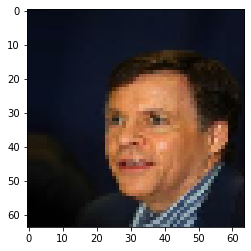

In [6]:
# test downloading and loading data

dataset = DatasetCache(use_manually_downloaded_dataset=False)
settings = Settings(collab_mode)
if collab_mode:
    settings.subdataset_dir = 'img_align_celeba'
dataset.load_data(settings)

if not collab_mode:
    display_image_from_dataset(dataset.data)

5_o_Clock_Shadow                0.0
Arched_Eyebrows                 1.0
Attractive                      1.0
Bags_Under_Eyes                 1.0
Bald                            0.0
Bangs                           0.0
Big_Lips                        0.0
Big_Nose                        1.0
Black_Hair                      0.0
Blond_Hair                      0.0
Blurry                          0.0
Brown_Hair                      0.0
Bushy_Eyebrows                  0.0
Chubby                          0.0
Double_Chin                     0.0
Eyeglasses                      0.0
Goatee                          0.0
Gray_Hair                       0.0
Heavy_Makeup                    0.0
High_Cheekbones                 0.0
Male                            0.0
Mouth_Slightly_Open             0.0
Mustache                        0.0
Narrow_Eyes                     0.0
No_Beard                        1.0
Oval_Face                       0.0
Pale_Skin                       0.0
Pointy_Nose                 

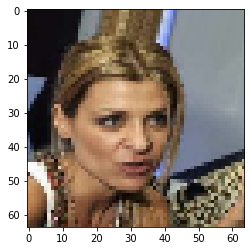

In [7]:
def prepare_embeddings_from_batch(batch, output_type=tf.float32):
    imgs, attributes = batch
    embeddings = tf.stack(list(attributes.values()))
    embeddings = tf.transpose(embeddings)
    embeddings = tf.cast(embeddings, dtype=output_type)
    return imgs, embeddings
    
def describe_embedding(orig_attributes, example):
    image, embedding_vector = example
    # display image
    img_ = (image+1)/2
    plt.imshow(img_)
    # describe image
    for key, value in zip(orig_attributes.keys(), embedding_vector):
        print(key, ' '*(30-len(key)), value.numpy())

def test_creating_embedding(dataset):
    for batch in dataset.data.take(1): # take one batch
        # get imgs and embeddings from that batch
        imgs, embeddings = prepare_embeddings_from_batch(batch)
        # describe first image in the batch and display it
        describe_embedding(batch[1], (imgs[0], embeddings[0]) )
    
# imgs, embeddings = prepare_embeddings_from_batch(batch, settings)
test_creating_embedding(dataset)

(64, 64, 3) 0.0 1.0


'ls' is not recognized as an internal or external command,
operable program or batch file.


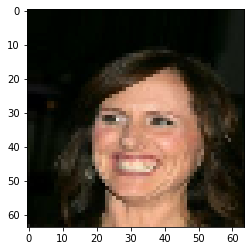

In [8]:
display_image_from_dataset(dataset.data)
if not collab_mode and not cmd_line_run:
    !ls "./datasets/celeb_a/img_align_celeba" | wc -l

Noise Generator

In [9]:
class NoiseGenerator(tf.keras.layers.Layer):

    def __init__(self, distribution_size):
        super().__init__()
        self.distribution_size = distribution_size
        # self.data_distributions = self.add_weight(shape=(num_classes, distribution_size), trainable=True)
        # self.data_distributions = tf.tile(tf.range(0, num_classes, dtype=tf.float32)[:, tf.newaxis], [1, distribution_size])
        # TODO:

    def call(self, inputs):
        # dists = tf.nn.embedding_lookup(self.data_distributions, inputs)
        # dists += tf.random.uniform(tf.shape(dists), -0.35, 0.35)
        # return dists
        # TODO
        return tf.random.normal([tf.shape(inputs)[0], self.distribution_size, 3])
    
    def diverse_distributions_loss(self):
        # TODO
        return None
    
    
class StackGANNoiseGenerator(tf.keras.layers.Layer):
    def __init__(self, distribution_size=100):
        super().__init__()
        self.distribution_size = distribution_size

    def call(self, inputs):
        # batch_size x distribution_size
        return tf.random.normal([tf.shape(inputs)[0], self.distribution_size])

Loss functions


In [10]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
kl = tf.keras.losses.KLDivergence()

def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss

def min_max_generator_loss(gen_out):
    return - min_max_discriminator_loss(tf.ones_like(gen_out), gen_out)

def stack_gan_discriminator_loss(real_out, fake_out):
    return min_max_discriminator_loss(real_out, fake_out)

def stack_gan_generator_loss(gen_out):
    return bce(tf.ones_like(gen_out), gen_out)

def w_discriminator_loss(real_out, gen_out):
    res = - (tf.reduce_mean(real_out) - tf.reduce_mean(gen_out))
    return res

def w_generator_loss(gen_out):
    return - tf.reduce_mean(gen_out)

def kl_generator_loss(real, gen):
    return kl(real, gen)

Layers for generator and discriminator from StackGAN

In [11]:
class GLU(tf.keras.layers.Layer):
    '''
    Multiplies first half of the last dimension
    by value of the second half of the last dimension.
    Layer introduced in https://github.com/hanzhanggit/StackGAN-v2/blob/master/code/model.py#L47
    
    Returns the same tensor with its last dimension halved and multiplied by sigmoid function activation.
    '''
    def __init__(self, **kwargs):
        super(GLU, self).__init__(**kwargs)

    def call(self, data):
        rank = data.shape.rank
        tensor_shape = data.shape.as_list()
        last_dim_half = tensor_shape[-1]//2
        # automatic slicing is impossible since the first dimension is None (batch size)
        

        # begins_1, begins_2 = np.zeros((rank,), dtype=np.int32), np.zeros((rank,), dtype=np.int32)
        # begins_2[-1] = last_dim_half # set offset for the last dimension

        # sizes = [tensor_shape[i] for i in range(rank)]
        # sizes[-1] = last_dim_half # get half of elements from the last dimension

        # return tf.slice(data, begins_1, sizes) * tf.math.sigmoid(tf.slice(data, begins_2, sizes))
        
        
        if rank == 2:
            return data[:, :last_dim_half] * tf.math.sigmoid(data[:, last_dim_half:])
        elif rank == 3:
            return data[:, :, :last_dim_half] * tf.math.sigmoid(data[:, :, last_dim_half:])
        elif rank == 4:
            return data[:, :, :, :last_dim_half] * tf.math.sigmoid(data[:, :, :, last_dim_half:])
        elif rank == 5:
            return data[:, :, :, :, :last_dim_half] * tf.math.sigmoid(data[:, :, :, :, last_dim_half:])

class GeneratorResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, index, **kwargs):
        super(GeneratorResidualLayer, self).__init__(**kwargs)
        
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters*2, 3, 1, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            GLU(),
            tf.keras.layers.Conv2D(filters, 3, 1, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
        ], name='generator_residual_layer_{}'.format(index))

    def call(self, data):
        residual = data
        out = self.block(data)
        return tf.keras.layers.add([out, residual])
    
class GeneratorUpsampleLayer(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(GeneratorUpsampleLayer, self).__init__(**kwargs)
        self.block = tf.keras.Sequential([
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(filters*2, 3, 1, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            GLU()
        ], name='generator_upsample_layer')

    def call(self, data):
        return self.block(data)

Generator


In [12]:
class GANNetwork(tf.keras.Model):
    def __init__(self, model_name="Network", **kwargs):
        self.is_conditional = False
        if 'is_conditional' in kwargs:
            self.is_conditional = kwargs['is_conditional']
            # remove that entry from kwargs
            # tf raises an exception when a keyword is not from allowed_kwargs set
            del kwargs['is_conditional']
        super().__init__(name=model_name, **kwargs)
        
        self.model = None
        

    def print_layers(self):
        print(self.model)
        for layer in self.model:
            print(layer.name, ":", layer.input_shape, "->", layer.output_shape)

    def summary(self):
        self.model.summary()
        
    @property
    def output_layer(self):
        return GANNetwork.get_last_layer(self.model)
    
    @property
    def output_shape(self):
        return GANNetwork.get_last_layer_output_shape(self.model)

    @tf.function
    def call(self, data, training):
        return self.model(data)

    def save_model(self, save_path):
        if not path.exists(save_path):
            os.makedirs(save_path)
        filename = path.join(save_path, '{}_{}'.format(self.name, get_time()))
        print("Saving model", self.name, "as", filename)
        self.model.save(filename)
        
    def compile_model(self, optimizer, loss):
        self.model.compile(optimizer=optimizer, loss=loss)
    
    @staticmethod
    def get_last_layer(model):
        return model.get_layer(index=-1)
    
    @staticmethod
    def get_last_layer_output_shape(model):
        layer = GANNetwork.get_last_layer(model)
        if layer is not None:
            return layer.output_shape[1:] # don't take batch_size into consideration
        return None

In [32]:
class GeneratorInitStage(GANNetwork):
    #input_shape = cfg.GAN.Z_DIM + cfg.GAN.EMBEDDING_DIM
    # or 
    # input_shape = cfg.GAN.Z_DIM if without conditioning
    def __init__(self, noise_shape, embeddings_shape, filters, settings, model_name="GeneratorInitStage", **kwargs):
        # filters should be `gen_init_filters`
        super().__init__(model_name, **kwargs)
        self.initial_factor = 16
        self.filters = self.initial_factor*filters
        # if is conditional then the second dimension is has size of concatenated noise and embedding
        
        self.in_shape = \
            (noise_shape[1] + embeddings_shape[1]) if self.is_conditional else noise_shape[1]
#         print('in shape', self.in_shape)
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(settings.init_w*settings.init_h*self.filters*2, input_shape=(self.in_shape, )),
            tf.keras.layers.BatchNormalization(),
            GLU(),
            tf.keras.layers.Reshape([settings.init_w, settings.init_h, self.filters]),
            GeneratorUpsampleLayer(self.filters//2),
            GeneratorUpsampleLayer(self.filters//4),
            GeneratorUpsampleLayer(self.filters//8),
            GeneratorUpsampleLayer(self.filters//16)
        ], name='generator_intermediate_init_output')
        
        self.output_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(3, 3, 1, 'same', input_shape=self.output_shape)
        ], name = 'generator_init_stage_output')
        
    @property
    def image_shape(self):
        return GANNetwork.get_last_layer_output_shape(self.output_model)
    
    @tf.function
    def call(self, data, training):
        intermediate_output = self.model(data)
        output = self.output_model(intermediate_output)
        return intermediate_output, output

In [14]:
def prepare_embedding_tensor(embedding, output_shape):
    '''
    Extends embedding tensor to match output shape.
    [batch, z] -> [batch, x, y, z], where x, y == output_shape
    '''
    embedding_shape = embedding.shape.as_list()
    # multiply output_shape[0] * output_shape[1]
    repeat_factor = tf.math.reduce_prod(output_shape)
    res = tf.keras.backend.repeat(embedding, repeat_factor)
    reshape_s = [embedding_shape[0], *output_shape, embedding_shape[-1]]
    # print(res.shape.as_list(), reshape_s)
    # reshape to [batch_size, output_shape[0], output_shape[1], embedding_size]
    return tf.reshape(res, reshape_s)

class GeneratorNextStage(GANNetwork):    
    @staticmethod
    def concat_embedding_and_previous_output(embedding, previous_output):
        repeat_factor = 1
#         print(embedding.shape.as_list(), previous_output.shape.as_list())
        if previous_output.shape.rank == 4:
            # get second and third dimension
            previous_output_shape = tf.slice(previous_output.shape, begin=[1], size=[2]).numpy()
        else:
            raise("Rank of the previous_output is not equal to 4")
        embedding = prepare_embedding_tensor(embedding, previous_output_shape)
        print('embedding', embedding.shape.as_list())
        return tf.concat([embedding, previous_output], axis=-1)
    

    def __init__(self, embeddings_shape, number_of_residuals, previous_stage_shape, filters, model_name="GeneratorInitStage", **kwargs):
        super().__init__(model_name, **kwargs)
        
        # size should be equal to
        # (init_stage_output_y, init_stage_output_x, init_stage_output_channels
        self.in_shape = previous_stage_shape
        if self.is_conditional:
            # concat embeddings with channel
            self.in_shape = (self.in_shape[0], self.in_shape[1], self.in_shape[2] + embeddings_shape[1])
        
        self.model = tf.keras.Sequential()
        
        self.model.add(tf.keras.layers.Dense(filters*2, input_shape=self.in_shape))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(GLU())
        
        self.model.add(GeneratorResidualLayer(filters, index=0))
        for i in range(number_of_residuals-1):
            self.model.add(GeneratorResidualLayer(filters, i+1))
        
        self.model.add(GeneratorUpsampleLayer(filters//2))
        
        self.output_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(3, 3, 1, 'same', input_shape=self.output_shape)
        ], name = 'generator_next_stage_output')
        
    @property
    def image_shape(self):
        return GANNetwork.get_last_layer_output_shape(self.output_model)
        
    @tf.function
    def call(self, data, training):
        intermediate_output = self.model(data)
        output = self.output_model(intermediate_output)
        return intermediate_output, output

Discriminator


In [15]:
class DiscriminatorEncodeImageLayer(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DiscriminatorEncodeImageLayer, self).__init__(**kwargs)
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, 4, 2, 'same', use_bias=False),
            tf.keras.layers.LeakyReLU(alpha=.2),
            
            tf.keras.layers.Conv2D(filters*2, 4, 2, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=.2),
            
            tf.keras.layers.Conv2D(filters*4, 4, 2, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=.2),
            
            
            tf.keras.layers.Conv2D(filters*8, 4, 2, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=.2),
        ], name='discriminator_encoding_layer')

    def call(self, data):
        return self.block(data)
    
class DiscriminatorDownBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, 4, 2, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=.2)
        ])
        
    def call(self, data):
        return self.block(data)
    
class Dicriminator3x3LeakyReLU(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, 3, 1, 'same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=.2)
        ])
        
    def call(self, data):
        return self.block(data)

In [16]:
class StackGANDiscriminator(GANNetwork):
    def __init__(self, input_shape, filters, embeddings_shape, output_image_size, model_name="StackGANDiscriminator", **kwargs):
        super().__init__(model_name, **kwargs)
        
        self.filters = filters
        
        # define intermediate models
        self.model = tf.keras.Sequential([
            DiscriminatorEncodeImageLayer(filters = self.filters, input_shape=input_shape)
        ])
        if output_image_size == 128:
            self.model.add(DiscriminatorDownBlock(filters=self.filters*16))
            self.model.add(Dicriminator3x3LeakyReLU(filters=self.filters*8))

        elif output_image_size == 256:
            self.model.add(DiscriminatorDownBlock(filters=self.filters*16))
            self.model.add(DiscriminatorDownBlock(filters=self.filters*32))
            self.model.add(Dicriminator3x3LeakyReLU(filters=self.filters*16))
            self.model.add(Dicriminator3x3LeakyReLU(filters=self.filters*8))

        self.conditional_model = tf.keras.Sequential()
        self.unconditional_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(1, kernel_size=4, strides=4, input_shape=self.output_shape)
        ])
        
        if self.is_conditional:
            conditional_input = (self.output_shape[0], self.output_shape[1], self.output_shape[2]+embeddings_shape[1])
            self.conditional_model.add(Dicriminator3x3LeakyReLU(filters=self.filters*8, input_shape=conditional_input))
            self.conditional_model.add(tf.keras.layers.Conv2D(1, kernel_size=4, strides=4))    
            
    @tf.function
    def call(self, data, training):
        if self.is_conditional:
            image, embedding = data # if unconditional then embedding == None
        else:
            image = data
            
        encoding_output = self.model(image)
        
        unconditional_output = self.unconditional_model(encoding_output)
        unconditional_loss = tf.math.sigmoid(unconditional_output[0,0,0,0])
        
        if self.is_conditional:
            # join embedding and image
            encode_layer_shape = self.model.output_shape[1:3] # get y and x of the model output shape
            embedding = prepare_embedding_tensor(embedding, encode_layer_shape)
            conditional_input = tf.keras.layers.concatenate([embedding, encoding_output], axis=-1)
            
            conditional_output = self.conditional_model(conditional_input)
            conditional_loss = tf.math.sigmoid(conditional_output[0,0,0,0])
            
            return conditional_loss, unconditional_loss
        
        return None, unconditional_loss

In [17]:
def test_models():
    is_conditional = False

    # test init and next stages
    generator_64 = GeneratorInitStage(noise_shape=z_dim,
                                    embeddings_shape=embeddings_shape,
                                    filters=gen_init_filters,
                                    is_conditional=is_conditional)
    # generator_64.summary()
    # generator_64.output_model.summary()

    generator_128 = GeneratorNextStage(
        embeddings_shape=embeddings_shape,
        number_of_residuals=2,
        previous_stage_shape=generator_64.output_shape,
        filters=gf_dim,
        is_conditional=is_conditional)
    # generator_128.summary()
    # generator_128.output_model.summary()

    generator_256 = GeneratorNextStage(
        embeddings_shape=embeddings_shape,
        number_of_residuals=2,
        previous_stage_shape=generator_128.output_shape,
        filters=gf_dim,
        is_conditional=is_conditional)

    # generator_256.summary()
    # generator_256.output_model.summary()

    discriminator_64 = StackGANDiscriminator(
        input_shape=generator_64.image_shape,
        filters=df_dim,
        embeddings_shape=embeddings_shape,
        output_image_size=64,
        is_conditional=is_conditional
    )
    # discriminator_64.summary()
    # discriminator_64.conditional_model.summary()
    # discriminator_64.unconditional_model.summary()

    discriminator_128 = StackGANDiscriminator(
        input_shape=generator_128.image_shape,
        filters=df_dim,
        embeddings_shape=embeddings_shape,
        output_image_size=128,
        is_conditional=is_conditional
    )
    # discriminator_128.summary()
    # discriminator_128.conditional_model.summary()
    # discriminator_128.unconditional_model.summary()

    discriminator_256 = StackGANDiscriminator(
        input_shape=generator_256.image_shape,
        filters=df_dim,
        embeddings_shape=embeddings_shape,
        output_image_size=256,
        is_conditional=is_conditional
    )
    # discriminator_256.summary()
    # discriminator_256.conditional_model.summary()
    # discriminator_256.unconditional_model.summary()

    noise_generator = StackGANNoiseGenerator()

    for batch in dataset.data.take(1):
        imgs, embedding = prepare_embeddings_from_batch(batch)

        noise = noise_generator(imgs)

        gen_64_input = tf.concat([embedding, noise], axis=1)\
            if is_conditional\
            else noise
        gen_64_out, gen_64_image_out = generator_64(gen_64_input, training=False)

        gen_128_input = GeneratorNextStage.concat_embedding_and_previous_output(
                embedding=embedding,
                previous_output=gen_64_out)\
            if is_conditional\
            else gen_64_out
        gen_128_out, gen_128_image_out = generator_128(gen_128_input, training=False)

        gen_256_input = GeneratorNextStage.concat_embedding_and_previous_output(
                embedding=embedding,
                previous_output=gen_128_out)\
            if is_conditional\
            else gen_128_out
        gen_256_out, gen_256_image_out = generator_256(gen_256_input, training=False)

        discr_64_input = [gen_64_image_out, embedding]\
            if is_conditional\
            else gen_64_image_out
        discr_64_output = discriminator_64(discr_64_input, training=False)

        discr_128_input = [gen_128_image_out, embedding]\
            if is_conditional\
            else gen_128_image_out
        discr_64_output = discriminator_128(discr_128_input, training=False)

        discr_256_input = [gen_256_image_out, embedding]\
            if is_conditional\
            else gen_256_image_out
        discr_256_output = discriminator_256(discr_256_input, training=False)
# test_models()

Training step

In [45]:
class ModelWrapper:
    def __init__(self, model_object, model_optimizer_fun, model_loss_fun):
        self.model = model_object
        self.optimizer_fun = model_optimizer_fun
        self.loss_fun = model_loss_fun
        self.loss = 0.0


def stack_gan_train_step_template(generators, discriminators, noise_generator, is_conditional):
    '''
    generators: {'name': ModelWrapper}
    discriminators: {'name': ModelWrapper}
    noise_generator: noise generator model
    '''
    training = True
    @tf.function
    def _train_step_template(images, embeddings): # to be executed before
        with tf.GradientTape() as d_tape_64,\
                tf.GradientTape() as d_tape_128,\
                tf.GradientTape() as d_tape_256,\
                tf.GradientTape() as g_tape:
            noise = noise_generator(images)

            ### 64 ###
            gen_64_input = tf.concat([embeddings, noise], axis=1)\
                if is_conditional\
                else noise
            gen_64_out, gen_64_image_out = generators['64'].model(gen_64_input, training=training)
            
            # discriminator
            discr_64_input = [gen_64_image_out, embeddings]\
                if is_conditional\
                else gen_64_image_out
            fake_discr_64_output = discriminators['64'].model([discr_64_input, embeddings], training=training)
            real_discr_64_output = discriminators['64'].model([images, embeddings], training=training)
            discriminators['64'].loss = discriminators['64']\
                .loss_fun(real_discr_64_output[0], fake_discr_64_output[0])
            if is_conditional:
                discriminators['64'].loss += discriminators['64']\
                    .loss_fun(real_discr_64_output[0], fake_discr_64_output[0])*unconditional_loss_coefficient
            
            # calculate generator loss (conditional + unconditional*unconditional_coeff)
            generators['64'].loss = generators['64'].loss_fun(
                fake_discr_64_output[1] * unconditional_loss_coefficient)
            if is_conditional:
                generators['64'].loss += generators['64'].loss_fun(fake_discr_64_output[0])


            ### 128 ###
            gen_128_input = GeneratorNextStage.concat_embedding_and_previous_output(
                    embedding=embeddings,
                    previous_output=gen_64_out)\
                if is_conditional\
                else gen_64_out
            gen_128_out, gen_128_image_out = generators['128'].model(gen_128_input, training=training)
            
            # discriminator
            discr_128_input = [gen_128_image_out, embeddings]\
                if is_conditional\
                else gen_128_image_out
            fake_discr_128_output = discriminators['128'].model([discr_128_input, embeddings], training=training)
            real_discr_128_output = discriminators['128'].model([images, embeddings], training=training)
            discriminators['128'].loss = discriminators['128']\
                .loss_fun(real_discr_128_output[0], fake_discr_128_output[0])
            if is_conditional:
                discriminators['128'].loss += discriminators['128']\
                    .loss_fun(real_discr_128_output[0], fake_discr_128_output[0])*unconditional_loss_coefficient
            
            # generator loss
            generators['128'].loss = generators['128'].loss_fun(
                fake_discr_128_output[1] * unconditional_loss_coefficient)
            if is_conditional:
                generators['128'].loss += generators['128'].loss_fun(fake_discr_128_output[0])
            

            ### 256 ###
            gen_256_input = GeneratorNextStage.concat_embedding_and_previous_output(
                    embedding=embeddings,
                    previous_output=gen_128_out)\
                if is_conditional\
                else gen_128_out
            gen_256_out, gen_256_image_out = generators['256'].model(gen_256_input, training=training)
            
            # discriminator
            discr_256_input = [gen_256_image_out, embeddings]\
                if is_conditional\
                else gen_256_image_out
            fake_discr_256_output = discriminators['256'].model([discr_256_input, embeddings], training=training)
            real_discr_256_output = discriminators['256'].model([images, embeddings], training=training)
            discriminators['256'].loss = discriminators['256']\
                .loss_fun(real_discr_256_output[0], fake_discr_256_output[0])
            if is_conditional:
                discriminators['256'].loss += discriminators['256']\
                    .loss_fun(real_discr_256_output[0], fake_discr_256_output[0])*unconditional_loss_coefficient
            # generator loss
            generators['256'].loss = generators['256'].loss_fun(
                fake_discr_256_output[1] * unconditional_loss_coefficient)
            if is_conditional:
                generators['256'].loss += generators['256'].loss_fun(fake_discr_256_output[0])

        
        error_g = tf.reduce_sum([x.loss for x in generators.values()])
        error_d = tf.reduce_sum([x.loss for x in discriminators.values()])
        
        g_grads = g_tape.gradient(generators['64'].loss,
                                  generators['64'].model.trainable_variables +
                                  generators['128'].model.trainable_variables +
                                  generators['256'].model.trainable_variables +
                                  noise.trainable_variables)
        
        d_64_grads = d_tape.gradient(discriminators['64'].loss,
                                  discriminators['64'].model.trainable_variables)
        discriminators['64']\
            .optimizer_fun\
            .apply_gradients(zip(d_64_grads, discriminators['64'].model.trainable_variables))
        
        d_128_grads = d_tape.gradient(discriminators['128'].loss,
                                  discriminators['128'].model.trainable_variables)
        discriminators['128']\
            .optimizer_fun\
            .apply_gradients(zip(d_128_grads, discriminators['128'].model.trainable_variables))
        
        d_256_grads = d_tape.gradient(discriminators['256'].loss,
                                  discriminators['256'].model.trainable_variables)
        discriminators['256']\
            .optimizer_fun\
            .apply_gradients(zip(d_256_grads, discriminators['256'].model.trainable_variables))
        
    return _train_step_template

Inference step



In [21]:
def stack_gan_gen_step_template(generators, noise_gen, is_conditional):
    @tf.function
    def _gen_step_template(images, embeddings):
        gen_64_input = tf.concat([embeddings, noise_gen(images)], axis=1)\
                if is_conditional\
                else noise
        gen_64_out, imgs_64 = generators['64'].model(gen_64_input, training=False)
        
        gen_128_input = GeneratorNextStage.concat_embedding_and_previous_output(
                    embedding=embeddings,
                    previous_output=gen_64_out)\
                if is_conditional\
                else gen_128_out
        gen_128_out, imgs_128 = generators['128'].model(gen_128_input, training=False)
        
        gen_256_input = GeneratorNextStage.concat_embedding_and_previous_output(
                    embedding=embeddings,
                    previous_output=gen_128_out)\
                if is_conditional\
                else gen_128_out
        _, imgs_256 = generators['256'].model(gen_256_input, training=False)
        return tf.clip_by_value([imgs_64, imgs_128, imgs_256], -1, 1)

    return _gen_step_template

Training

In [46]:
def train(train_step, gen_step, epochs, data, settings, ckptManager, tensorboard_manager, save_images=True, display_images=True):
    loss_descriptions = ['discriminator loss', 'generator loss'] #, 'kl generator loss']
    imgs_sizes = ['64', '128', '256']
    timestamp = get_time()
    max_batch_iter = 0
    for epoch in range(epochs):
        batch_iter = 0
        epoch_start = time.time()
        for batch in data:
            images, embedding = prepare_embeddings_from_batch(batch)
            batch_iter+=1
            train_result = train_step(images, embedding)
            tensorboard_manager.save('train',
                                     [np.average(loss) for loss in train_result],
                                     loss_descriptions,
                                     timestamp,
                                     'scalars',
                                     epoch*max_batch_iter+batch_iter
                                    )
            if (batch_iter+1) % 50 == 0:
                print("Saving checkpoint, iter", batch_iter+1)
                ckptManager.save()
        # save the number of batches in one epoch
        if epoch == 0:
            max_batch_iter = batch_iter

        epoch_end = time.time()
        print('-'*30)
        print('Epoch {0}/{1}, duration {2}'.format(epoch+1, epochs, epoch_end-epoch_start))
        #if (epoch + 1) % 5 == 0 or epoch == epochs-1:
        print("Saving checkpoint, epoch", epoch+1)
        ckptManager.save()

        images_to_generate = [img[0] for img in data.take(1)][0].numpy() # take one batch from train_data
        generated_imgs = gen_step(images_to_generate)
        
        for (generated, size) in zip(generated_imgs, imgs_sizes):
            tensorboard_manager.save('train',
                                     generated,
                                     '{}_{}_{}/{}'.format(settings.run_name, size, epoch+1, epochs),
                                     timestamp,
                                     'images',
                                     epoch
                                    )
            
        
            print(size)
            show_images(generated, epoch, settings, save_images=save_images, display_images=display_images)
        print('+'*30)


In [ ]:
# check how images are displayed/saved
def test_image_generation(settings):
    save_images = True
    display_images = True
    batch_size = 10
    data = load_dataset(batch_size=settings.batch_size)
    
    generator_input_shape = (64, 3)
    generator = Generator(input_shape=generator_input_shape)
    noise = NoiseGenerator(64)
    
    gen_step = gen_step_template(
        generator=generator,
        noise=noise
    )
    images_to_generate = [img for img in data.take(1)][0].numpy() # take one batch from train_data
    generated = gen_step(images_to_generate)
    show_images(generated, -1, settings, save_images=save_images, display_images=display_images)
    
# test_image_generation(Settings(collab_mode))

Training with Wasserstein loss function

In [47]:
class StackGANGeneratorWrapper:
    def __init__(self, settings):
        self.generators = dict()
        self.generators['64'] = ModelWrapper(
                        model_object = GeneratorInitStage(noise_shape=settings.z_dim,
                            embeddings_shape=settings.embeddings_shape,
                            filters=settings.gen_init_filters,
                            is_conditional=settings.is_conditional,
                            settings=settings),
                        model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
                        model_loss_fun = stack_gan_generator_loss
                        )
                                             
        self.generators['128'] = ModelWrapper(
                        model_object = GeneratorNextStage(
                            embeddings_shape=settings.embeddings_shape,
                            number_of_residuals=2,
                            previous_stage_shape=self.generators['64'].model.output_shape,
                            filters=settings.gf_dim,
                            is_conditional=settings.is_conditional),
                        model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
                        model_loss_fun = stack_gan_generator_loss
                        )
                    
        self.generators['256'] = ModelWrapper(
                        model_object = GeneratorNextStage(
                            embeddings_shape=settings.embeddings_shape,
                            number_of_residuals=2,
                            previous_stage_shape=self.generators['128'].model.output_shape,
                            filters=settings.gf_dim,
                            is_conditional=settings.is_conditional),
                        model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
                        model_loss_fun = stack_gan_generator_loss
                        )
        self.settings = settings
        
    def __getitem__(self, key):
        return self.generators[key]
        
class StackGANDiscriminatorWrapper:
    def __init__(self, generators, settings):
        self.discriminators = dict()
        self.discriminators['64'] = ModelWrapper(
            model_object = StackGANDiscriminator(
                input_shape=generators['64'].model.image_shape,
                filters=settings.df_dim,
                embeddings_shape=settings.embeddings_shape,
                output_image_size=64,
                is_conditional=settings.is_conditional
            ),
            model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
            model_loss_fun = stack_gan_discriminator_loss
        )

        self.discriminators['128'] = ModelWrapper(
            model_object = StackGANDiscriminator(
                input_shape=generators['128'].model.image_shape,
                filters=settings.df_dim,
                embeddings_shape=settings.embeddings_shape,
                output_image_size=128,
                is_conditional=settings.is_conditional
            ),
            model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
            model_loss_fun = stack_gan_discriminator_loss
        )
        
        self.discriminators['256'] = ModelWrapper(
            model_object = StackGANDiscriminator(
                input_shape=generators['256'].model.image_shape,
                filters=settings.df_dim,
                embeddings_shape=settings.embeddings_shape,
                output_image_size=256,
                is_conditional=settings.is_conditional
            ),
            model_optimizer_fun = tf.keras.optimizers.Adam(1e-4),
            model_loss_fun = stack_gan_discriminator_loss
        )
        self.settings = settings
        
    def __getitem__(self, key):
            return self.discriminators[key]

In [48]:
env = Environment(collab_mode)
generators = StackGANGeneratorWrapper(env.settings)
discriminators = StackGANDiscriminatorWrapper(generators, env.settings)
env.settings.epochs = 30
env.settings.batch_size = 500
env.settings.subdataset_dir='img_align_celeba'
env.settings.save_models = True
print(env.settings.get_base_path)
# load data
env.datasetCache.load_data(env.settings)
# set models
env.models['generators'] = generators
env.models['discriminators'] = discriminators
# setup tensorboard
env.tensorboard = TensorboardManager()
env.tensorboard.initialize(env.settings)

noise = StackGANNoiseGenerator(100)

checkpoint = tf.train.Checkpoint(generator_64_opt=env.models['generators']['64'].optimizer_fun,
                                 generator_128_opt=env.models['generators']['128'].optimizer_fun,
                                 generator_256_opt=env.models['generators']['256'].optimizer_fun,
                                 discriminator_64_opt=env.models['discriminators']['64'].optimizer_fun,
                                 discriminator_128_opt=env.models['discriminators']['128'].optimizer_fun,
                                 discriminator_256_opt=env.models['discriminators']['256'].optimizer_fun,
                                 generator_64=env.models['generators']['64'].model,
                                 generator_128=env.models['generators']['128'].model,
                                 generator_256=env.models['generators']['256'].model,
                                 discriminator_64=env.models['discriminators']['64'].model,
                                 discriminator_128=env.models['discriminators']['128'].model,
                                 discriminator_256=env.models['discriminators']['256'].model)
env.checkpointManager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                                   directory=env.settings.checkpoint_dir,
                                                   max_to_keep=3
                                                  )
if env.checkpointManager.latest_checkpoint:
    print("restoring state from", env.checkpointManager.latest_checkpoint)
    checkpoint\
        .restore(env.checkpointManager.latest_checkpoint)
    
train_step = stack_gan_train_step_template(
    generators=env.models['generators'],
    discriminators=env.models['discriminators'],
    noise_generator=noise,
    is_conditional=env.settings.is_conditional
)

gen_step = stack_gan_gen_step_template(
    generators=env.models['generators'],
    noise_gen=noise,
    is_conditional=settings.is_conditional
)

D:\iswd_2\gsn\laby\FaceGenerator
downloading and loading data


Initialized tensorboard log dir with path D:\iswd_2\gsn\laby\FaceGenerator\saved_state\stack_gan_run_img_align_celeba\tensorboard_logs
open tensorboard with command
tensorboard --logdir D:\iswd_2\gsn\laby\FaceGenerator\saved_state\stack_gan_run_img_align_celeba\tensorboard_logs


In [49]:
print("Start time", get_time())
print('%'*30)
start = time.time()

train(
    train_step=train_step,
    gen_step=gen_step,
    epochs=env.settings.epochs,
    data=env.datasetCache.data,
    settings=env.settings,
    ckptManager=env.checkpointManager,
    tensorboard_manager=env.tensorboard
)

end = time.time()
print('%'*30)
print("End time", get_time())
print("seconds elapsed", end - start)

if env.settings.save_models:
    print('saving models')
    for model in env.models:
        env.models[model].save_model(env.settings.model_save_path)


Start time 13-01-2020_01-20-10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


ValueError: in converted code:

    <ipython-input-45-45a7e1ebc7bc>:36 _train_step_template  *
        discriminators['64'].loss = discriminators['64']\
    <ipython-input-10-5da2bcd13aa6>:13 stack_gan_discriminator_loss  *
        return min_max_discriminator_loss(real_out, fake_out)
    <ipython-input-10-5da2bcd13aa6>:5 min_max_discriminator_loss  *
        real_loss = bce(tf.ones_like(real_out), real_out)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\losses.py:126 __call__
        losses = self.call(y_true, y_pred)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\losses.py:221 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\losses.py:994 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\backend.py:2117 mean
        return math_ops.reduce_mean(x, axis, keepdims)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\util\dispatch.py:180 wrapper
        return target(*args, **kwargs)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\ops\math_ops.py:1881 reduce_mean
        name=name))
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\ops\gen_math_ops.py:6391 mean
        name=name)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Invalid reduction dimension -1 for input with 0 dimensions. for 'binary_crossentropy/Mean' (op: 'Mean') with input shapes: [], [] and with computed input tensors: input[1] = <-1>.


uwagi:
* na początku generowane obrazki są białe, bardzo małe odchylenie w wartościach pikseli ok 17 dla skali 0-255
* generator używa tylko skali np 52-160
* później generator uczy się zwiększać odchylenie i wartości pikseli na obrazkach zwiększają się do przedziału 0-255
